In [1]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from PIL import Image

import numpy as np

import copy
import pickle
import os

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
with open('./pretrained/ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()

### 4-a. load a target image

In [3]:
path = './data/crop/'

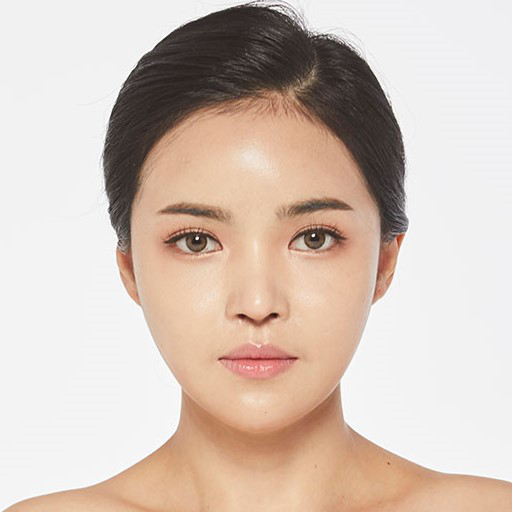

In [4]:
sample_path = path + 'after2_crop.jpg'
target_img = Image.open(sample_path)
target_img

### 4-b. transform image file to numpy array

In [5]:
target_img.size

(512, 512)

In [6]:
target_uint8 = np.array(target_img, dtype=np.uint8)
target_uint8.shape

(512, 512, 3)

In [7]:
target_uint8[0]

array([[241, 241, 241],
       [241, 241, 241],
       [241, 241, 241],
       ...,
       [239, 239, 241],
       [239, 239, 241],
       [239, 239, 241]], dtype=uint8)

### 4-c. load the pre-trained Generator

In [8]:
device = torch.device('cuda')
G_eval = copy.deepcopy(G).eval().requires_grad_(False).to(device) # use g as the evaluation mode (do not track gradients)

### 4-d. Compute w stats

In [9]:
z_samples = np.random.randn(10000, G_eval.z_dim) # G_eval.z_dim == 512, (10000,512)
w_samples = G_eval.mapping(torch.from_numpy(z_samples).to(device), None)
w_samples.size()

Setting up PyTorch plugin "bias_act_plugin"... Failed!


torch.Size([10000, 18, 512])

In [10]:
w_samples = w_samples[:,:1,:].cpu().numpy().astype(np.float32)
w_samples

array([[[-0.10221421,  1.0814816 , -0.02584909, ..., -0.3339097 ,
         -0.03017815, -0.07552846]],

       [[-0.18984182,  0.95335233, -0.24648398, ..., -0.31465775,
         -0.05473082, -0.0184309 ]],

       [[-0.04981362, -0.03254331,  0.7622736 , ..., -0.1390961 ,
         -0.12982999, -0.04441308]],

       ...,

       [[-0.17772122, -0.19017786, -0.13451456, ..., -0.23559925,
         -0.19079469, -0.05017768]],

       [[ 0.53623337, -0.15944494, -0.35475722, ..., -0.26674435,
          0.15401264, -0.25428575]],

       [[ 0.43965954, -0.36672845,  0.05014866, ..., -0.05190119,
          0.28308088,  2.9066193 ]]], dtype=float32)

In [11]:
w_samples.shape

(10000, 1, 512)

In [12]:
w_avg = np.mean(w_samples, axis=0, keepdims=True) 
w_avg.shape # mean of w_samples

(1, 1, 512)

In [13]:
w_std = (np.sum((w_samples - w_avg)**2)/10000)**0.5
w_std

10.00644417363131

### 4-e. Setup noise inputs

In [14]:
noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

### 4-f. Load VGG16 feature detector

In [15]:
import dnnlib

In [16]:
url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
with dnnlib.util.open_url(url) as f:
    vgg16 = torch.jit.load(f).eval().to(device)

### 4-g. Extract features for target image

In [17]:
target = torch.tensor(target_uint8.transpose([2,0,1]), device=device)
target.size()

torch.Size([3, 512, 512])

In [18]:
target

tensor([[[241, 241, 241,  ..., 239, 239, 239],
         [241, 241, 241,  ..., 239, 239, 239],
         [241, 241, 241,  ..., 239, 239, 239],
         ...,
         [247, 248, 253,  ..., 222, 222, 220],
         [247, 246, 242,  ..., 224, 224, 223],
         [245, 236, 213,  ..., 223, 224, 223]],

        [[241, 241, 241,  ..., 239, 239, 239],
         [241, 241, 241,  ..., 239, 239, 239],
         [241, 241, 241,  ..., 239, 239, 239],
         ...,
         [249, 248, 252,  ..., 181, 181, 179],
         [251, 248, 239,  ..., 183, 183, 182],
         [251, 238, 210,  ..., 182, 183, 182]],

        [[241, 241, 241,  ..., 241, 241, 241],
         [241, 241, 241,  ..., 241, 241, 241],
         [241, 241, 241,  ..., 241, 241, 241],
         ...,
         [248, 246, 247,  ..., 151, 151, 149],
         [250, 245, 232,  ..., 153, 153, 152],
         [251, 235, 203,  ..., 152, 153, 152]]], device='cuda:0',
       dtype=torch.uint8)

In [19]:
target = target.unsqueeze(0).to(device).to(torch.float32)
target.size()

torch.Size([1, 3, 512, 512])

In [20]:
target

tensor([[[[241., 241., 241.,  ..., 239., 239., 239.],
          [241., 241., 241.,  ..., 239., 239., 239.],
          [241., 241., 241.,  ..., 239., 239., 239.],
          ...,
          [247., 248., 253.,  ..., 222., 222., 220.],
          [247., 246., 242.,  ..., 224., 224., 223.],
          [245., 236., 213.,  ..., 223., 224., 223.]],

         [[241., 241., 241.,  ..., 239., 239., 239.],
          [241., 241., 241.,  ..., 239., 239., 239.],
          [241., 241., 241.,  ..., 239., 239., 239.],
          ...,
          [249., 248., 252.,  ..., 181., 181., 179.],
          [251., 248., 239.,  ..., 183., 183., 182.],
          [251., 238., 210.,  ..., 182., 183., 182.]],

         [[241., 241., 241.,  ..., 241., 241., 241.],
          [241., 241., 241.,  ..., 241., 241., 241.],
          [241., 241., 241.,  ..., 241., 241., 241.],
          ...,
          [248., 246., 247.,  ..., 151., 151., 149.],
          [250., 245., 232.,  ..., 153., 153., 152.],
          [251., 235., 203.,  ...

In [21]:
target = F.interpolate(target, size=(256, 256), mode='area') # Resize to pass through the vgg16 network.
target.size()

torch.Size([1, 3, 256, 256])

In [22]:
target

tensor([[[[241.0000, 241.0000, 241.0000,  ..., 239.0000, 239.0000, 239.0000],
          [241.0000, 241.0000, 241.0000,  ..., 239.0000, 239.0000, 239.0000],
          [241.0000, 241.0000, 241.0000,  ..., 239.0000, 239.0000, 239.0000],
          ...,
          [246.5000, 242.5000, 247.7500,  ..., 221.0000, 219.5000, 219.7500],
          [246.5000, 252.2500, 240.2500,  ..., 222.2500, 220.7500, 219.2500],
          [243.5000, 218.0000, 198.2500,  ..., 223.0000, 222.5000, 223.5000]],

         [[241.0000, 241.0000, 241.0000,  ..., 239.0000, 239.0000, 239.0000],
          [241.0000, 241.0000, 241.0000,  ..., 239.0000, 239.0000, 239.0000],
          [241.0000, 241.0000, 241.0000,  ..., 239.0000, 239.0000, 239.0000],
          ...,
          [245.5000, 242.7500, 248.5000,  ..., 180.0000, 178.5000, 178.7500],
          [247.0000, 249.5000, 229.5000,  ..., 181.2500, 179.7500, 178.2500],
          [247.0000, 211.5000, 176.5000,  ..., 182.0000, 181.5000, 182.5000]],

         [[241.0000, 241.0000,

In [23]:
target_features = vgg16(target, resize_images=False, return_lpips=True)
target_features

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [24]:
target_features.sum()

tensor(592.3789, device='cuda:0')

In [25]:
target_features.size()

torch.Size([1, 7995392])

### 4-h. Set optimizer and Initiate noise

In [26]:
# suggested default hyper-parameter (official)
num_steps = 1000
initial_learning_rate = 0.1
# ========================================= #

w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)

# Init noise.
for buf in noise_bufs.values():
    buf[:] = torch.randn_like(buf)
    buf.requires_grad = True

### 4-i. projection(training)

In [27]:
num_steps = 1000
# suggested default hyper-parameter (official)
lr_rampdown_length = 0.25
lr_rampup_length = 0.05
initial_noise_factor = 0.05
noise_ramp_length = 0.75
regularize_noise_weight = 1e5
# ========================================= #

for step in tqdm(range(num_steps)):
    # Learning rate schedule.
    t = step / num_steps
    w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
    lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
    lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
    lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
    lr = initial_learning_rate * lr_ramp
    for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
    # Synthesize image from opt_w
    w_noise = torch.randn_like(w_opt) * w_noise_scale
    ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
    synth_images = G.synthesis(ws, noise_mode='const')
    
    # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
    synth_images = (synth_images + 1) * (255/2)
    if synth_images.shape[2] > 256:
        synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')
        
    # Features for synth images.
    synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
    dist = (target_features - synth_features).square().sum() # Calculate the difference between two feature maps (target vs synth) generated through vgg. 
                                                             # This is the point of projection.
    # Noise regularization.
    reg_loss = 0.0
    for v in noise_bufs.values():
        noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
        while True:
            reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
            reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
            if noise.shape[2] <= 8:
                break
            noise = F.avg_pool2d(noise, kernel_size=2)
    loss = dist + reg_loss * regularize_noise_weight
    
    # Step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    print(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')
    
    # Save projected W for each optimization step.
    w_out[step] = w_opt.detach()[0]

    # Normalize noise.
    with torch.no_grad():
        for buf in noise_bufs.values():
            buf -= buf.mean()
            buf *= buf.square().mean().rsqrt()

  0%|          | 0/1000 [00:00<?, ?it/s]

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step    1/1000: dist 0.61 loss 5717.19
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting u

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step   18/1000: dist 0.41 loss 959.15
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step   36/1000: dist 0.27 loss 411.31
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step   44/1000: dist 0.24 loss 134.06
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step   62/1000: dist 0.22 loss 31.25
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step   79/1000: dist 0.21 loss 6.54 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step   97/1000: dist 0.19 loss 9.30 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  114/1000: dist 0.17 loss 9.64 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  115/1

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  132/1000: dist 0.16 loss 9.32 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  150/1000: dist 0.18 loss 17.34
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  167/1000: dist 0.17 loss 8.04 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  185/1000: dist 0.16 loss 8.04 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  202/1000: dist 0.15 loss 14.71
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  220/1000: dist 0.16 loss 12.82
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  237/1000: dist 0.15 loss 3.38 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  255/1000: dist 0.13 loss 4.11 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  264/1000: dist 0.14 loss 10.73
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  281/1000: dist 0.13 loss 3.44 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  299/1000: dist 0.13 loss 15.30
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  316/1000: dist 0.15 loss 17.46
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  334/1000: dist 0.13 loss 14.30
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  351/1000: dist 0.13 loss 4.60 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  369/1000: dist 0.14 loss 5.62 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  378/1000: dist 0.12 loss 7.58 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  395/1000: dist 0.13 loss 27.24
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  413/1000: dist 0.12 loss 5.07 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  430/1000: dist 0.12 loss 16.17
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  448/1000: dist 0.12 loss 4.01 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  465/1000: dist 0.11 loss 0.32 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  483/1000: dist 0.11 loss 0.49 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  492/1000: dist 0.11 loss 12.36
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  509/1000: dist 0.11 loss 3.42 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  527/1000: dist 0.11 loss 12.05
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  544/1000: dist 0.10 loss 11.21
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  562/1000: dist 0.11 loss 16.47
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  579/1000: dist 0.10 loss 15.58
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  597/1000: dist 0.10 loss 40.93
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  606/1000: dist 0.10 loss 35.92
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  623/1000: dist 0.10 loss 13.27
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  641/1000: dist 0.10 loss 22.42
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  658/1000: dist 0.10 loss 9.16 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  676/1000: dist 0.10 loss 0.29 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  693/1000: dist 0.10 loss 2.54 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  711/1000: dist 0.10 loss 0.61 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  720/1000: dist 0.09 loss 0.32 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  737/1000: dist 0.09 loss 0.39 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  755/1000: dist 0.09 loss 23.94
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  772/1000: dist 0.09 loss 8.93 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  790/1000: dist 0.09 loss 1.34 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  807/1000: dist 0.09 loss 0.26 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  825/1000: dist 0.09 loss 0.10 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  834/1000: dist 0.09 loss 0.09 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  851/1000: dist 0.09 loss 0.09 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  869/1000: dist 0.09 loss 0.09 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  886/1000: dist 0.09 loss 0.09 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  904/1000: dist 0.09 loss 0.09 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  921/1000: dist 0.09 loss 0.09 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  939/1000: dist 0.09 loss 0.09 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  948/1000: dist 0.09 loss 0.09 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  965/1000: dist 0.09 loss 0.09 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step  983/1000: dist 0.09 loss 0.09 
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up 

Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
step 1000/1000: dist 0.09 loss 0.09 


In [28]:
w_out.size()

torch.Size([1000, 1, 512])

In [29]:
w_out.repeat([1, G.mapping.num_ws, 1]).size()

torch.Size([1000, 18, 512])

In [30]:
projected_w_steps = w_out.repeat([1, G.mapping.num_ws, 1])
projected_w = projected_w_steps[-1]
print(projected_w.size())
print(projected_w)

torch.Size([18, 512])
tensor([[ 1.6711, -0.8712,  2.0715,  ...,  0.3284, -0.0463, -1.5772],
        [ 1.6711, -0.8712,  2.0715,  ...,  0.3284, -0.0463, -1.5772],
        [ 1.6711, -0.8712,  2.0715,  ...,  0.3284, -0.0463, -1.5772],
        ...,
        [ 1.6711, -0.8712,  2.0715,  ...,  0.3284, -0.0463, -1.5772],
        [ 1.6711, -0.8712,  2.0715,  ...,  0.3284, -0.0463, -1.5772],
        [ 1.6711, -0.8712,  2.0715,  ...,  0.3284, -0.0463, -1.5772]],
       device='cuda:0')


In [31]:
np_w = projected_w.cpu().numpy()
np.save('./output/weight/after2', np_w)

### 4-j. Compare the target image with the generated image

In [4]:
synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const')
synth_image = (synth_image + 1) * (255/2)
synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [33]:
synth_image.shape

(1024, 1024, 3)

In [34]:
target_uint8.shape

(512, 512, 3)

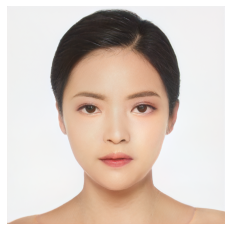

In [35]:
plt.imshow(synth_image)
plt.axis('off')
plt.show()

In [ ]:
plt.savefig('./output/weight/after2.jpg')

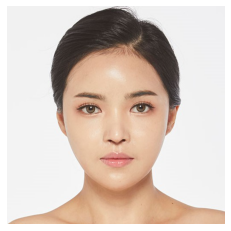

In [36]:
plt.imshow(target_uint8)
plt.axis('off')
plt.show()